,temperatura,tiempos,T0,conductividad
0,21.3,0,24.283333,0.00895
1,23.9,3,24.283333,0.00807
2,24.8,6,24.283333,0.00755
3,25.1,9,24.283333,0.00726
4,25.3,12,24.283333,0.00710
5,25.3,15,24.283333,0.00692


,temperatura,tiempos,T0,conductividad
0,29.6,25,29.8,0.00717
1,29.8,28,29.8,0.00720
2,29.8,31,29.8,0.00713
3,29.9,34,29.8,0.00713
4,29.9,37,29.8,0.00713


,temperatura,T0,tiempos,conductividad
0,34.2,34.54,47,0.00748
1,35.0,34.54,50,0.00747
2,34.8,34.54,53,0.00745
3,34.9,34.54,56,0.00745
4,34.9,34.54,59,0.00746


,"Tiempo, min",conductividad,Temperatura,at,ct,xa,xe
0,0,0.008950,21.300000,0.039149,0.010851,0.217013,0.217013
1,3,0.008070,23.900000,0.032406,0.017594,0.351886,0.351886
2,6,0.007550,24.800000,0.028421,0.021579,0.431584,0.431584
3,9,0.007260,25.100000,0.026198,0.023802,0.476030,0.476030
4,12,0.007100,25.300000,0.024972,0.025028,0.500553,0.500553
5,15,0.006920,25.300000,0.023593,0.026407,0.528140,0.528140
6,Media,0.007642,24.283333,0.029123,0.020877,0.417534,0.417534


,"Tiempo, min",conductividad,Temperatura,at,ct,xa,xe
0,25,0.007170,29.6,0.019957,0.030043,0.600866,0.600866
1,28,0.007200,29.8,0.020172,0.029828,0.596559,0.596559
2,31,0.007130,29.8,0.019670,0.030330,0.606608,0.606608
3,34,0.007130,29.9,0.019670,0.030330,0.606608,0.606608
4,37,0.007130,29.9,0.019670,0.030330,0.606608,0.606608
5,Media,0.007152,29.8,0.019828,0.030172,0.603450,0.603450


,"Tiempo, min",conductividad,Temperatura,at,ct,xa,xe
0,47,0.007480,34.20,0.017829,0.032171,0.643411,0.643411
1,50,0.007470,35.00,0.017761,0.032239,0.644773,0.644773
2,53,0.007450,34.80,0.017625,0.032375,0.647496,0.647496
3,56,0.007450,34.90,0.017625,0.032375,0.647496,0.647496
4,59,0.007460,34.90,0.017693,0.032307,0.646134,0.646134
5,Media,0.007462,34.76,0.017707,0.032293,0.645862,0.645862


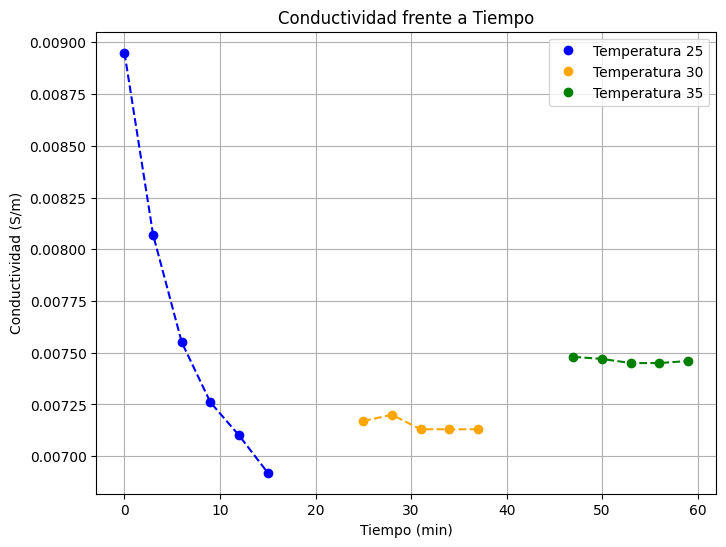

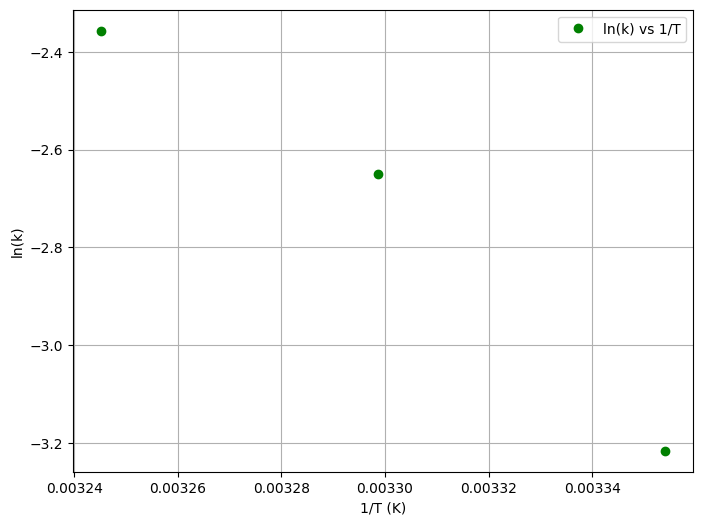

,k (m^-1 s^-1),1/T (K),ln(k)
0,0.040105,0.003354,-3.216242
1,0.070574,0.003299,-2.651093
2,0.094710,0.003245,-2.356936


,Ea J/mol,A L/mol s
0,65745.775863,1.381297e+10


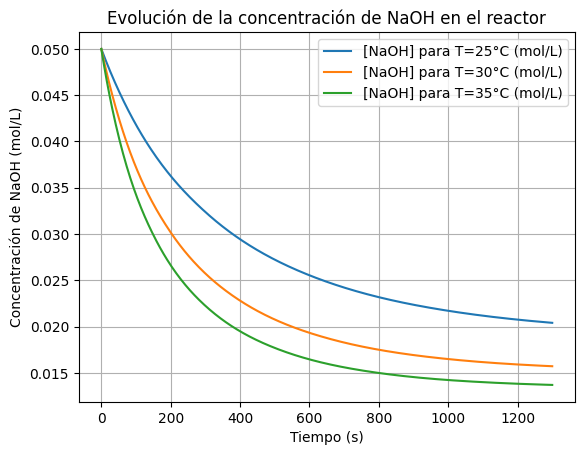

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import linregress
from scipy.integrate import solve_ivp
import pickle

Temperatura_objetivo = [25, 30, 35]


Fa = 40  # ml/min
Fb = 40  # ml/min
Au = 0.1
bu = 0.1    
c0 = 0.0
V = 1.45  # Volumen del reactor en litros
uno_partido_T = []
valor_k = []
ln_k = []
medidas = [
    {'temperatura': [21.3, 23.9, 24.8, 25.1,25.3,25.3],
     'tiempos' : [0, 3, 6, 9, 12, 15],
     'T0': np.mean([21.3, 23.9, 24.8, 25.1,25.3,25.3]),
     'conductividad': [8.95/1000, 8.07/1000, 7.55/1000, 7.26/1000, 7.1/1000, 6.92/1000]},
    {'temperatura': [29.6, 29.8, 29.8, 29.9, 29.9],
     'tiempos' : [25, 28, 31, 34, 37],
     'T0' : np.mean([29.6, 29.8, 29.8, 29.9, 29.9]),
     'conductividad': [7.17/1000, 7.2/1000, 7.13/1000, 7.13/1000,  7.13/1000]},
    {'temperatura': [34.2, 35, 34.8, 34.9, 34.9],
     'T0' : np.mean([35.1, 34.4, 34.4, 34.4, 34.4]),
     'tiempos' : [47, 50, 53, 56, 59],
     'conductividad': [7.48/1000, 7.47/1000, 7.45/1000, 7.45/1000, 7.46/1000]},
]

dataframes_medidas = {}
for i, medida in enumerate(medidas):
    df = pd.DataFrame(medida)
    # Asignar un nombre específico al DataFrame basado en la temperatura objetivo
    nombre_df = f"Temperatura_{Temperatura_objetivo[i]}"
    dataframes_medidas[nombre_df] = df
    display(dataframes_medidas[nombre_df])

plt.figure(figsize=(8, 6))
colores = ['blue', 'orange', 'green']

# Usar enumerate para acceder al índice y las medidas
for i, medida in enumerate(medidas):
    a0 = (Fa / (Fa + Fb)) * Au
    b0 = (Fb / (Fa + Fb)) * bu
    Temperatura = Temperatura_objetivo[i]  # Usar el índice i
    T0 = medida['T0']+273.15

    if b0 < a0:
        cinf = b0 
    else:
        cinf = a0

    alpha_c_inf = 0.07 * (1 + 0.0284 * (T0 - 294)) * cinf
    alpha_a0 = 0.195 * (1 + 0.0184 * (T0 - 294)) * a0

    if c0 == 0:
        Alpha0 = alpha_a0 

    ainf = a0 - b0 if a0 >= b0 else 0
    alpha_a_inf = 0.195 * (1 + 0.0184 * (T0 - 294)) * ainf if ainf != 0 else 0
    alpha_inf = alpha_c_inf + alpha_a_inf

    Temp = medida['temperatura']
    C = medida['conductividad']
    T = medida['tiempos']

    at = []
    ct = []
    xa = []
    xe = []

    for c, temp, t in zip(C, Temp, T):
        at_val = (ainf - a0) * ((Alpha0 - c) / (Alpha0 - alpha_inf)) + a0
        ct_val = cinf * ((Alpha0 - c) / (Alpha0 - alpha_inf))
        xa_val = (a0 - at_val) / a0
        xe_val = ct_val / cinf
        
        # Almacenar los resultados
        at.append(at_val)
        ct.append(ct_val)
        xa.append(xa_val)
        xe.append(xe_val)
    
    # Crear un DataFrame con los resultados del bucle
    df_result = pd.DataFrame({
        'Tiempo, min': T,
        'conductividad': C,
        'Temperatura': Temp,
        'at': at,
        'ct': ct,
        'xa': xa,
        'xe': xe
    })
    # Calcular la media de las columnas
    media_at = df_result['at'].mean()
    media_ct = df_result['ct'].mean()
    media_xa = df_result['xa'].mean()
    media_xe = df_result['xe'].mean()
    media_Tiempo = df_result['Tiempo, min'].mean()
    media_conductividad = df_result['conductividad'].mean()
    media_Temperatura = df_result['Temperatura'].mean()

    # Agregar fila de medias al final del DataFrame
    df_media = pd.DataFrame({
        'Tiempo, min': ['Media'],
        'conductividad': [media_conductividad],  # Ningún valor para la columna de conductividad
        'Temperatura': [media_Temperatura],  # Ningún valor para la columna de Temperatura
        'at': [media_at],
        'ct': [media_ct],
        'xa': [media_xa],
        'xe': [media_xe]
    })

    # Concatenar la fila de medias al DataFrame original
    df_result = pd.concat([df_result, df_media], ignore_index=True)
    display(df_result)
    valor_media_at = df_result['at'].iloc[-1]
    if i ==0:
        k = ((Fa / 60000 + (Fb / 60000)) / V) * ((a0 - (df_result['at'].iloc[-3:-1].mean())) / ((df_result['at'].iloc[-3:-1].mean()) ** 2))  # m^-1 s^-1
    else:
        k = ((Fa / 60000 + (Fb / 60000)) / V) * ((a0 - valor_media_at) / (valor_media_at ** 2))  # m^-1 s^-1
    valor_k = np.append(valor_k, k)  # Almacenar en valor_k
    uno_partido_T.append(1/(Temperatura_objetivo[i] + 273.15))
    ln_k.append(np.log(k))
    plt.plot(T, C, marker='o', linestyle='None', color=colores[i], label=f"Temperatura {Temperatura}")  # Cambia el label
    plt.plot(T, C, linestyle='--', color=colores[i])
    

# Configurar el título y etiquetas de la gráfica
plt.title('Conductividad frente a Tiempo')
plt.xlabel('Tiempo (min)')
plt.ylabel('Conductividad (S/m)')
plt.legend()  # Añadir la leyenda para identificar cada serie
plt.grid(True)  # Añadir una cuadrícula para mayor claridad
plt.show()  # Mostrar la gráfica

# Gráfica de ln(k) vs 1/T
plt.figure(figsize=(8, 6))
plt.plot(uno_partido_T, ln_k, marker='o', linestyle='None', color=colores[i], label='ln(k) vs 1/T')
plt.xlabel('1/T (K)')
plt.ylabel('ln(k)')
plt.legend()
plt.grid(True)
plt.show()
df_k = pd.DataFrame({
    'k (m^-1 s^-1)': valor_k,
    '1/T (K)': uno_partido_T,
    'ln(k)': ln_k
})
display(df_k)
slope, intercept, r_value, _, std_err = linregress(uno_partido_T, ln_k)

R = 8.314
Ea = -slope * R
A = np.exp(intercept)

df_arrhenius = pd.DataFrame({
    'Ea J/mol': [Ea],
    'A L/mol s': [A]
})
display(df_arrhenius)
Fa  = Fa/60000 #L/s
t_eval = np.linspace(0, 1300, 500)


# r = k*CA²
# d(V*CA)/dt = F* CA0 -F*CA - r*V  por tanto F
# d(CA)/dt = (F/V)*(CA0 - CA) - k*CA²

def reactor_edo(t, at, Fa, k, V, a0):
    da_dt = (Fa / V) * (a0 - at) - k * at**2
    return da_dt
for j in range(len(valor_k)):
    temperatura = Temperatura_objetivo[j]
    t_span = [0, 1300]
    k_j = valor_k[j]  # Usar el valor correspondiente de k
    sol = solve_ivp(reactor_edo, t_span, [a0], args=(Fa, k_j, V, a0), t_eval=t_eval)
    t = sol.t
    a_t = sol.y[0]
    plt.plot(t, a_t, label=f'[NaOH] para T={temperatura}°C (mol/L)')
    if j == 0:
        with open('datos_serie_1.pkl', 'wb') as f:
            pickle.dump((t, a_t), f)

plt.xlabel('Tiempo (s)')
plt.ylabel('Concentración de NaOH (mol/L)')
plt.title('Evolución de la concentración de NaOH en el reactor')
plt.legend()
plt.grid(True)
plt.show()
    